In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torch
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from torch.optim import Optimizer
import math
import torchvision.transforms as transforms
import torchvision
import os

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        


###### Custom Optimizer

In [3]:
class SWATS(Optimizer):
    r"""Implements Adam and SGD mix algorithm.
    """

    def __init__(self,
                 params, tolerance, lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,
                 adam_w=0.5, sgd_w=0.5):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(tolerance = tolerance,eta = eta,
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,
            adam_w=adam_w, sgd_w=sgd_w, phase = 'ADAM'
        )
        super(SWATS, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SWATS, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self,c,Mix_batch_count, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        difference = []
        corrected = []
        sca = []
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad

                state = self.state[p]

                
                
                    
                if group['phase'] == 'SGD':
                    #print("The phase is now SGD")
                    d_p_sgd = self.sgd_step(grad, group, p)
                    p.data.add_(-d_p_sgd * group['lr'])
                    #print("SGD OG lr",group['lr'])
                    continue
                    
                #print("The phase is now ADAM")
                d_p_adam, step_size,exp_avg2, bias_correction2, state['diff'] = self.adam_step(grad, group, p)
                    
                w = d_p_adam*step_size*-1
                p.data.add_(w)
                    
                
                #print("len of grad and p =", len(grad.view(-1)), len(w.view(-1)))
                p_view = w.view(-1)
                pg = p_view.dot(grad.view(-1))
                beta1, beta2 = group['betas']

                if pg != 0:
                    # the non-orthognal scaling estimate
                    scaling = p_view.dot(p_view) / -pg
                    exp_avg2.mul_(beta2).add_(scaling, alpha=1 - beta2)

                    # bias corrected exponential average
                    corrected_exp_avg = exp_avg2 / bias_correction2
                    
                    difference.append(corrected_exp_avg.item() - scaling.item())
                    corrected.append(corrected_exp_avg.item())
                    sca.append(scaling.item())
                    
                    state['diff'] = abs(corrected_exp_avg.item() - scaling.item())
                    
                
                    if (state['step'] > 1 and state['diff'] < group['tolerance'] and corrected_exp_avg > 0 ):
                        
                        print("corrected lr  = ",corrected_exp_avg.item())
                        group['lr'] = corrected_exp_avg.item()
                        print("SGD OG lr",group['lr'])
                        
                        group['phase'] = 'SGD'
                        
                        
                

                    
    

        return loss,difference, corrected, sca


    
    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            #state['SGD_lr'] = 0.01
            state['diff'] = 10.0
            state['exp_avg2'] = p.new(1).fill_(0)
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size, state['exp_avg2'], bias_correction2, state['diff']

    def sgd_step(self, grad, group, p):
        d_p = grad
        
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay)
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        return d_p

In [4]:
class MY(Optimizer):
    r"""Implements Adam and SGD mix algorithm.
    """

    def __init__(self,
                 params,
                 lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,SGD_weight = 0.5, Adam_weight = 0.8, opPrint = True):    
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,Adam_weight = Adam_weight, SGD_weight = SGD_weight,
            phase = 'ADAM', SGD_lr = 0.01
        )
        super(MY, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(MY, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self ,current_epoch, No_epoch, adam_phase, mix_phase, Mix_batch_count,opPrint = True, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        #print("MY")
        #print(Mix_batch_count)
        inc_list = np.linspace(0,1,int((adam_phase*No_epoch + mix_phase*No_epoch)-adam_phase*No_epoch))
        #inc_list = np.logspace(np.log10(0.01), np.log10(1), int((adam_phase*No_epoch + mix_phase*No_epoch)-adam_phase*No_epoch))

        listt = []
        for group in self.param_groups:
            
            if current_epoch <= adam_phase*No_epoch:
                
                group['phase'] = "ADAM"
                if opPrint == True:
                    print("ADAM | Current epoch = ",current_epoch)


            elif adam_phase*No_epoch <= current_epoch <= (adam_phase*No_epoch + mix_phase*No_epoch):

                group['phase'] = 'MIX'
                group['Adam_weight'] = 1-inc_list[Mix_batch_count]
                group['SGD_weight'] = inc_list[Mix_batch_count]
                
                if opPrint == True:
                    print("\nMix batch count = ", Mix_batch_count)
                    print("\nMIX | Current epoch = ",current_epoch)
                    print("MIX | SGD Weight = ",group['SGD_weight'])
                    print("MIX | Adam Weight = ",group['Adam_weight'])

            else:
                group['phase'] = 'SGD'
                if opPrint == True:
                    print("SGD | Current epoch = ",current_epoch)
            
            for p in group['params']:

                if p.grad is None:
                    continue
                    
                grad = p.grad   
                state = self.state[p]

                if group['phase'] == 'SGD':
                    #print("SGD_LR = ", abs(group['SGD_lr']))
                    
                    d_p_sgd = self.sgd_step(grad, group, p)
                    
                    p.add_(d_p_sgd, alpha=-abs(group['SGD_lr']))
                    
                    continue
                
                if group['phase'] == 'ADAM':
                    #print("The phase is now ADAM")
                    d_p_adam, step_size,exp_avg2, bias_correction2, state['diff'] = self.adam_step(grad, group, p)
                    
                    w = d_p_adam*step_size*-1
                    p.data.add_(w)
                    
                    
                if group['phase'] == 'MIX':
                    #print("The phase is now MIX")
                    
                    
                    d_p_adam, step_size, exp_avg2, bias_correction2, state['diff']  = self.adam_step(grad, group, p)
                    
                    w = d_p_adam*step_size*-1

                    d_p_sgd = self.sgd_step(grad, group, p)
                    
                    megred_d_p = group['SGD_weight'] * d_p_sgd + group['Adam_weight'] * d_p_adam
            
                    merged_lr = group['SGD_weight'] * abs(group['SGD_lr']) + group['Adam_weight'] * step_size

                    p.add_(megred_d_p, alpha=-merged_lr)
                            
                
                
                #print("len of grad and p =", len(grad.view(-1)), len(w.view(-1)))
                p_view = w.view(-1)
                pg = p_view.dot(grad.view(-1))
                beta1, beta2 = group['betas']

                if pg != 0:
                    # the non-orthognal scaling estimate
                    scaling = p_view.dot(p_view) / -pg
                    exp_avg2.mul_(beta2).add_(scaling, alpha=1 - beta2)

                    # bias corrected exponential average
                    corrected_exp_avg = exp_avg2 / bias_correction2
                    listt.append(abs(corrected_exp_avg.item()))
                
                
                    if current_epoch == (adam_phase*No_epoch-1):
                        print("The phase is now MIX")
                        group['SGD_lr'] = corrected_exp_avg.item() # worked0.0134
                        print("SGD_LR = ", abs(group['SGD_lr']))
                    
                    
        
        checker = group['phase']
        return loss,checker,listt
        
               
    def check(self, group):
        if group == 'MIX':
            return True


    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            #state['SGD_lr'] = 0.01
            state['diff'] = 10.0
            state['exp_avg2'] = p.new(1).fill_(0)
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size, state['exp_avg2'], bias_correction2, state['diff']

    def sgd_step(self, grad, group, p):
        d_p = grad
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay)
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        return d_p

### Data Prep

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
train = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train) # Data augmentation is only done on training images
test = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
 

#### Our Models

In [7]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # input is color image, hence 3 i/p channels. 16 filters, kernal size is tuned to 3 to avoid overfitting, stride is 1 , padding is 1 extract all edge features.
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) # We double the feature maps for every conv layer as in pratice it is really good.
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500) # I/p image size is 32*32, after 3 MaxPooling layers it reduces to 4*4 and 64 because our last conv layer has 64 outputs. Output nodes is 500
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10) # output nodes are 10 because our dataset have 10 different categories
    def forward(self, x):
      x = F.relu(self.conv1(x)) #Apply relu to each output of conv layer.
      x = F.max_pool2d(x, 2, 2) # Max pooling layer with kernal of 2 and stride of 2
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64) # flatten our images to 1D to input it to the fully connected layers
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) # Applying dropout b/t layers which exchange highest parameters. This is a good practice
      x = self.fc2(x)
      return x

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Trainer

In [9]:
def TrainVal(model, traindata , testdata, opti ,
           batch_size, loss_fn, epochs , clipping, 
           lr,  weight_decay,
                       
           mom, dampening, nest,
                       
           betas, eps,tolerance, eta, amsgra,
                       
           adam_w, sgd_w,
        
           final_lr,
             
           adam_phase, mix_phase,
                       
           plots = False, Print = False, opPrint = False):
    

    #splitting training data into train and validation set
    test_abs = int(len(traindata) * 0.8)
    train_subset, val_subset = random_split(traindata, [test_abs, len(traindata) - test_abs])
    
    #Loading data into torch loader
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size = batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size = batch_size, shuffle = True)
    
    #Runs model on correct device
    model = model.to(device)
    
    criterion = loss_fn
    
    if opti == "ADAM":
        optimizer = optim.Adam(model.parameters(), lr=lr,betas=betas, eps=eps, amsgrad= amsgra,
                               weight_decay=weight_decay)
    elif opti == "SGD":
        optimizer = optim.SGD(model.parameters(),lr=lr, momentum = mom,dampening = dampening,
                              weight_decay=weight_decay,nesterov=nest )
    elif opti == "ADABOUND":
        optimizer =  AdaBound(model.parameters(), lr=lr, betas=betas, final_lr = final_lr, gamma=1e-3,
                 eps=eps, weight_decay=weight_decay, amsbound=False)
    elif opti == "MY":
        optimizer = MY(model.parameters(),
                 lr=lr, weight_decay=weight_decay,
                 betas=betas, eps=eps, amsgrad=amsgra,momentum=mom, dampening=dampening,
                       nesterov=nest,SGD_weight = 0.0, Adam_weight = 0.5,opPrint =  opPrint)
        
    elif opti == 'SWATS' :
        optimizer = SWATS( model.parameters(),tolerance, lr=lr,
                 betas=betas, eps=eps, amsgrad=amsgra,
                 momentum=mom, dampening=dampening, nesterov=nest,
                 adam_w=adam_w, sgd_w=sgd_w)
        
    elif opti == 'NewSwats':
        optimizer = NewSwats(model.parameters(),tolerance, eta, lr=lr,
                 betas=betas, eps=eps, amsgrad=amsgra,
                 momentum=mom, dampening=dampening, nesterov=nest,
                 adam_w=adam_w, sgd_w=sgd_w)
    else:
        optimizer = AdamSGD(model.parameters(), lr=lr,
                 betas=betas, eps=eps, amsgrad=amsgra,
                 momentum=mom, dampening=dampening, nesterov=nest,
                 adam_w=adam_w, sgd_w=sgd_w)
        
        
    #Some metrics
    epoch_list = []
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    batchy_norm = []
    epoch_norm = []
    switch = []
    Mix_batch_count = 0
    diff = []
    corr = []
    sc = []
    listtt = []
    for e in range(epochs): # training our model, put input according to every batch.
        #Train metrics
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        
        #Entering Training mode
        model.train()
        
        #Gradient Norm Metric
        batch_norm = []
        
        for inputs, labels in train_loader:
            
            inputs = inputs.to(device) 
            labels = labels.to(device)
            
            #Outputs of model
            outputs = model(inputs) 
            #Loss of outputs
            loss = criterion(outputs, labels)

            optimizer.zero_grad() 
            
            #gradient step
            loss.backward() 
            
           

            #Grad norm cals
            param_normm = []
            tot = 0
            for p in model.parameters():
                tt = torch.flatten(p.grad).numpy()
                param_normm = np.concatenate((param_normm,tt))

            batch_norm.append(np.sqrt(np.sum(np.power(param_normm,2))))
            batchy_norm.append(np.sqrt(np.sum(np.power(param_normm,2))))
            
            yyy = 0
            if  opti == "SWATS":
                
                losso, difference, corrected, sca= optimizer.step(e+1,18)
                
                diff.append(difference)
                corr.append(corrected)
                sc.append(sca)
                    
                    
            elif opti == 'MY':
                    
                loss0,group,listt = optimizer.step(e+1, epochs,adam_phase, mix_phase, Mix_batch_count)
                listtt.append(listt)
                
            else:
                optimizer.step()

            #Predictions
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            #Loss
            train_loss += loss.item()
        
        if opti == 'MY':
            
            if group == 'MIX':
                Mix_batch_count += 1
                
        epoch_list.append(e+1)
        

        epoch_norm.append(np.mean(batch_norm))
        train_loss_list.append(train_loss/train_total)
        train_acc_list.append(100*train_correct/train_total)
        if Print == True:
            print('Epoch: {} \tTrain Loss: {:.4f}\t Acc: {:.2f}%'.format(e+1, train_loss/train_total, 100*train_correct/(train_total)) )
        
              
        #Validation
        # Calculate Accuracy 
        model.eval() 
  

        
        #Val metrics
        val_loss = 0.0
        val_correct = 0.0
        val_total = 0.0
        
        with torch.no_grad(): # we do not need gradient for validation.
            for val_inputs, val_labels in val_loader:
                
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)

                #Predictions
                _, predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (predicted == val_labels).sum().item()
                
                val_loss += val_loss.item()
 

        val_loss = np.asarray(val_loss/val_total)

        val_loss_list.append(val_loss)

        
        val_acc_list.append(100*val_correct/ val_total)
        
        if Print == True:
            print('Epoch: {} \tVal Loss: {:.4f}\t Acc: {:.2f}%'.format(e+1, val_loss/val_total, 100*val_correct/ val_total ))
        
        
    if plots == True:
        
        plt.plot(epoch_list,epoch_norm)
        plt.xlabel("Epochs")
        plt.ylabel("Grad Norm")
        plt.title("Grad Norm vs Number of Epochs")
        plt.show()


        plt.plot(epoch_list,train_loss_list)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Number of Epochs")
        plt.show()

        plt.plot(epoch_list,train_acc_list)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training acc vs Number of Epochs")
        plt.show()

            
        plt.plot(epoch_list,val_loss_list)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("val loss vs Number of Epochs")
        plt.show()

        plt.plot(epoch_list,val_acc_list)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("val Accuracy vs Number of Epochs")
        plt.show()
        

    return epoch_list, train_loss_list,train_acc_list, val_loss_list, val_acc_list, batchy_norm, epoch_norm,diff, corr, sc,listtt


In [10]:
def testing(model, testdata ,
           batch_size, loss_fn ,
         plots = False, Print = False):   
    
    ##Testing
    test_correct = 0
    test_total = 0
    test_loss = 0
    
    
    model.eval() # Required for Evaluation/Test

    y_pred_list = []
    y_actual = []



    test_loader = torch.utils.data.DataLoader(test, batch_size =batch_size, shuffle = True)

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:

            # Convert our images and labels to Variables to accumulate Gradients
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            # Predict Output
            output = model(test_inputs)

            # Calculate Loss
            loss = loss_fn(output, test_labels)
            
            test_loss += loss.item()
            
            # Get predictions from the maximum value

            #Predictions
            _, predicted = torch.max(output, 1)
            test_total += test_labels.size(0)
            test_correct += (predicted == test_labels).sum().item()

            y_pred_list += predicted
            y_actual += test_labels



        # calculate average test loss and accuracy over an epoch
        test_loss = test_loss/test_total
        accuracy_test =  100 * test_correct/ test_total
        
    if Print == True:
        print("test Accuracy = ",accuracy_test)
        print("test loss = ",test_loss)
        
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return accuracy_test, y_pred_list, y_actual

### Hyperparameters

In [11]:
MY_c = 'green'
SGD_c = 'dodgerblue'
ADAM_c = 'red'
SWATS_c = 'black'

ADAM | Current epoch =  1
The phase is now MIX
SGD_LR =  4.484595775604248
The phase is now MIX
SGD_LR =  2.940678596496582
The phase is now MIX
SGD_LR =  7.120392799377441
The phase is now MIX
SGD_LR =  1.8110038042068481
The phase is now MIX
SGD_LR =  10.45745849609375
The phase is now MIX
SGD_LR =  1.0753415822982788
The phase is now MIX
SGD_LR =  20.535768508911133
The phase is now MIX
SGD_LR =  1.4128330945968628
The phase is now MIX
SGD_LR =  2.9869463443756104
The phase is now MIX
SGD_LR =  0.13612708449363708
ADAM | Current epoch =  1
The phase is now MIX
SGD_LR =  2.7489519119262695
The phase is now MIX
SGD_LR =  1.7593759298324585
The phase is now MIX
SGD_LR =  4.883900165557861
The phase is now MIX
SGD_LR =  1.2361069917678833
The phase is now MIX
SGD_LR =  7.559246063232422
The phase is now MIX
SGD_LR =  0.7543428540229797
The phase is now MIX
SGD_LR =  17.101062774658203
The phase is now MIX
SGD_LR =  1.170230507850647
The phase is now MIX
SGD_LR =  2.1933486461639404
The 

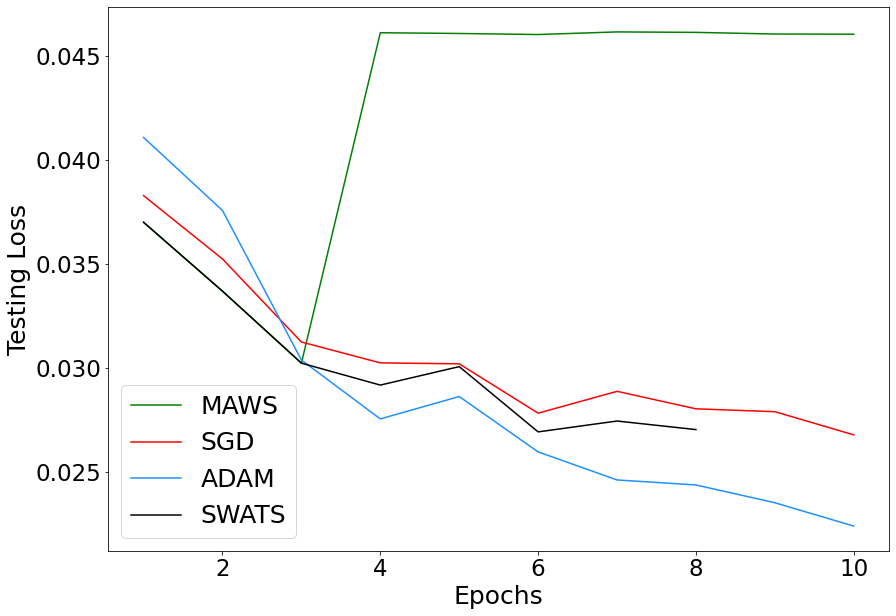

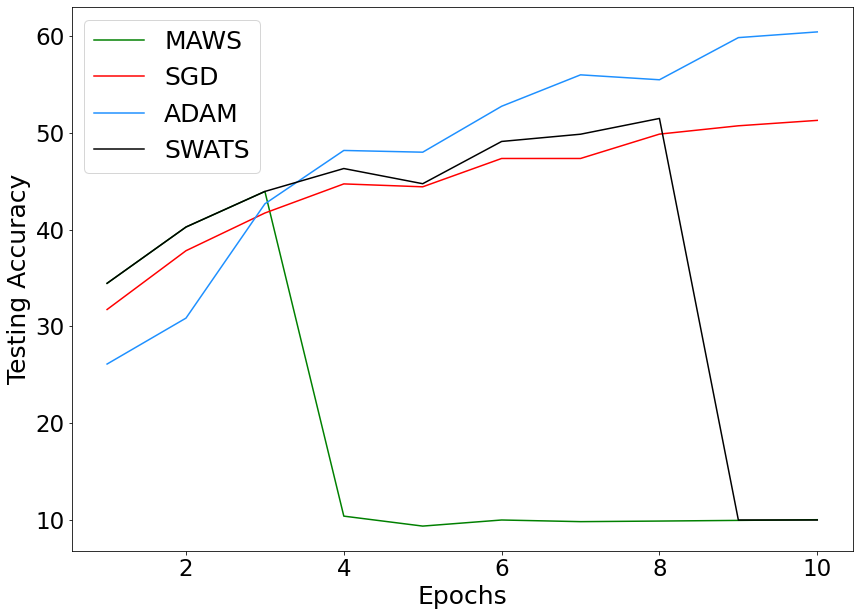

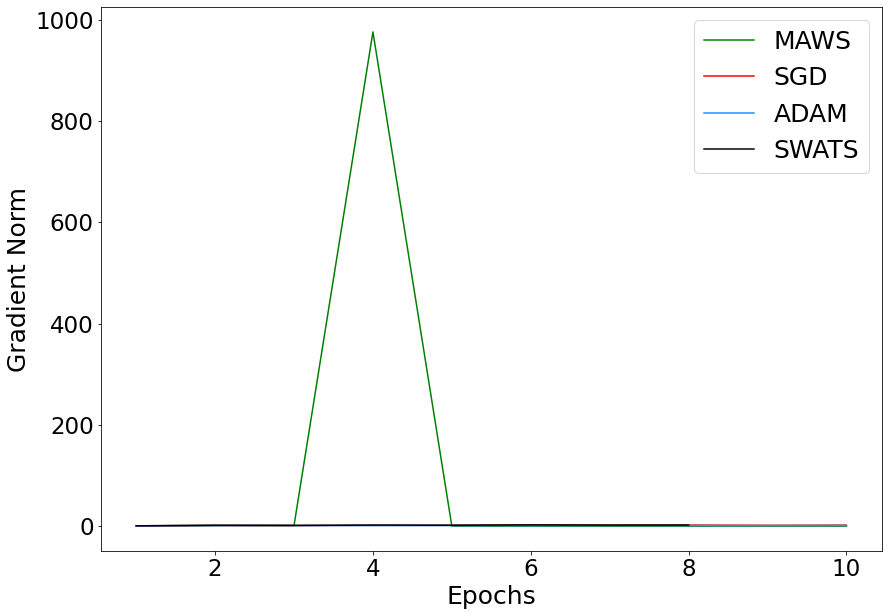

In [12]:
import time

opti = 'MY'
batch_size = 1024 # set at 1024 after tuning
loss_fn = nn.CrossEntropyLoss()

clipping = False # set to false
lr =  0.001
hidden_dim = 32
drop = 0.2
weight_decay = 0.0
mom = 0.95
dampening = 0
nest = False #set
Betas = (0.9,0.999) # set
eps = 1e-8 # set
amsgra = False #set
adam_w = 0.5
sgd_w= 0.5
tolerance = 0.01 # with 1e-3 switches at 7
eta = 0.0003
final_lr = 0.001
adam_phasee = 0.2
mix_phasee = 0.5  #0.4 works




plots = False
Print = True
opPrint = False
i=0

epochs = 10


seed_everything(1234)


model=LeNet()

epoch_list, train_loss_list,train_acc_list, val_loss_list, val_acc_list, batchy_norm, epoch_norm,diff,corr, sc,listtt = TrainVal(
model, train , test, opti ,batch_size, loss_fn, epochs , clipping, lr,  weight_decay,mom, dampening, nest,(0.9,0.999),
eps,tolerance,eta, amsgra,adam_w,
1-adam_w, final_lr,adam_phase=adam_phasee, mix_phase=mix_phasee,
plots = plots, Print = Print, opPrint = opPrint)

accuracy_test, y_pred_list, y_actual = testing(model, test ,32, loss_fn ,plots = True, Print = True)


tot = 0
j = 1
for p in range(5):
    tot +=val_acc_list[-j]
    j +=1

Validation_Acc_result = tot/5

print("Validation_Acc_result = ",Validation_Acc_result)




fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot()
ax.plot(epoch_list, np.asarray(val_loss_list)*100, label = "MAWS", c = MY_c)
ax.set_xlabel('Epochs', fontsize = 25)
ax.set_ylabel('Testing Loss', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=23)
ax.tick_params(axis='both', which='minor', labelsize=23)
ax.legend(fontsize = 25)

fig = plt.figure(figsize=(14,10))
ax2 = fig.add_subplot()
#ax2.set_ylim(40, 83)
#print(val_acc_list)
ax2.plot(epoch_list, val_acc_list, label = "MAWS", c = MY_c)
ax2.set_xlabel('Epochs', fontsize = 25)
ax2.set_ylabel('Testing Accuracy', fontsize = 25)
ax2.tick_params(axis='both', which='major', labelsize=23)
ax2.tick_params(axis='both', which='minor', labelsize=23)
ax2.legend(fontsize = 25)

fig = plt.figure(figsize=(14,10))
ax3 = fig.add_subplot()
ax3.plot(epoch_list, epoch_norm, label = "MAWS", c = MY_c)
ax3.set_xlabel('Epochs', fontsize = 25)
ax3.set_ylabel('Gradient Norm', fontsize = 25)
ax3.tick_params(axis='both', which='major', labelsize=23)
ax3.tick_params(axis='both', which='minor', labelsize=23)
ax3.legend(fontsize = 25)
#############################################################################################################
#ADAM

opti = 'ADAM'
lr = 0.0007


seed_everything(1234)
#Note h,d are not being used
model=LeNet()

epoch_list, train_loss_list,train_acc_list, val_loss_list, val_acc_list, batchy_norm, epoch_norm,diff,corr, sc,listttt = TrainVal(
model, train , test, opti ,batch_size, loss_fn, epochs , clipping, lr,  weight_decay,mom, dampening, nest,(0.9,0.999),
eps,tolerance,eta, amsgra,adam_w,
1-adam_w, final_lr,adam_phase=adam_phasee, mix_phase=mix_phasee,
plots = plots, Print = Print, opPrint = opPrint)

accuracy_test, y_pred_list, y_actual = testing(model, test ,32, loss_fn ,plots = True, Print = True)


tot = 0
j = 1
for p in range(5):
    tot +=val_acc_list[-j]
    j +=1

Validation_Acc_result = tot/5

print("Validation_Acc_result = ",Validation_Acc_result)



ax.plot(epoch_list, np.asarray(val_loss_list)*100, label = "SGD", c =ADAM_c)
ax.set_xlabel('Epochs', fontsize = 25)
ax.set_ylabel('Testing Loss', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=23)
ax.tick_params(axis='both', which='minor', labelsize=23)
ax.legend(fontsize = 25)


ax2.plot(epoch_list, val_acc_list, label = "SGD", c =ADAM_c)
ax2.set_xlabel('Epochs', fontsize = 25)
ax2.set_ylabel('Testing Accuracy', fontsize = 25)
ax2.tick_params(axis='both', which='major', labelsize=23)
ax2.tick_params(axis='both', which='minor', labelsize=23)
ax2.legend(fontsize = 25)


ax3.plot(epoch_list, epoch_norm, label = "SGD", c =ADAM_c)
ax3.set_xlabel('Epochs', fontsize = 25)
ax3.set_ylabel('Gradient Norm', fontsize = 25)
ax3.tick_params(axis='both', which='major', labelsize=23)
ax3.tick_params(axis='both', which='minor', labelsize=23)
ax3.legend(fontsize = 25)

#############################################################################################################
#SGD

opti = 'SGD'
lr =  0.08


seed_everything(1234)
model=LeNet()

epoch_list, train_loss_list,train_acc_list, val_loss_list, val_acc_list, batchy_norm, epoch_norm,diff,corr, sc,listttt = TrainVal(
model, train , test, opti ,batch_size, loss_fn, epochs , clipping, lr,  weight_decay,mom, dampening, nest,(0.9,0.999),
eps,tolerance,eta, amsgra,adam_w,
1-adam_w, final_lr,adam_phase=adam_phasee, mix_phase=mix_phasee,
plots = plots, Print = Print, opPrint = opPrint)

accuracy_test, y_pred_list, y_actual = testing(model, test ,32, loss_fn ,plots = True, Print = True)


tot = 0
j = 1
for p in range(5):
    tot +=val_acc_list[-j]
    j +=1

Validation_Acc_result = tot/5

print("Validation_Acc_result = ",Validation_Acc_result)



ax.plot(epoch_list, np.asarray(val_loss_list)*100, label = "ADAM", c =SGD_c)
ax.set_xlabel('Epochs', fontsize = 25)
ax.set_ylabel('Testing Loss', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=23)
ax.tick_params(axis='both', which='minor', labelsize=23)
ax.legend(fontsize = 25)


ax2.plot(epoch_list, np.asarray(val_acc_list), label = "ADAM", c =SGD_c)
ax2.set_xlabel('Epochs', fontsize = 25)
ax2.set_ylabel('Testing Accuracy', fontsize = 25)
ax2.tick_params(axis='both', which='major', labelsize=23)
ax2.tick_params(axis='both', which='minor', labelsize=23)
ax2.legend(fontsize = 25)


ax3.plot(epoch_list, epoch_norm, label = "ADAM", c =SGD_c)
ax3.set_xlabel('Epochs', fontsize = 25)
ax3.set_ylabel('Gradient Norm', fontsize = 25)
ax3.tick_params(axis='both', which='major', labelsize=23)
ax3.tick_params(axis='both', which='minor', labelsize=23)
ax3.legend(fontsize = 25)






#############################################################################################################
#SWATS

opti = 'SWATS'

clipping = False # set to false
lr = 0.001
tolerance = 0.0001 # with 1e-3 switches at 7

seed_everything(1234)
model=LeNet()

epoch_list, train_loss_list,train_acc_list, val_loss_list, val_acc_list, batchy_norm, epoch_norm,diff,corr, sc,listttt = TrainVal(
model, train , test, opti ,batch_size, loss_fn, epochs , clipping, lr,  weight_decay,mom, dampening, nest,(0.9,0.999),
eps,tolerance,eta, amsgra,adam_w,
1-adam_w, final_lr,adam_phase=adam_phasee, mix_phase=mix_phasee,
plots = plots, Print = Print, opPrint = opPrint)

accuracy_test, y_pred_list, y_actual = testing(model, test ,32, loss_fn ,plots = True, Print = True)


tot = 0
j = 1
for p in range(5):
    tot +=val_acc_list[-j]
    j +=1

Validation_Acc_result = tot/5

print("Validation_Acc_result = ",Validation_Acc_result)



ax.plot(epoch_list, np.asarray(val_loss_list)*100, label = "SWATS", c =SWATS_c)
ax.set_xlabel('Epochs', fontsize = 25)
ax.set_ylabel('Testing Loss', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=23)
ax.tick_params(axis='both', which='minor', labelsize=23)
ax.legend(fontsize = 25)


ax2.plot(epoch_list, np.asarray(val_acc_list), label = "SWATS", c =SWATS_c)
ax2.set_xlabel('Epochs', fontsize = 25)
ax2.set_ylabel('Testing Accuracy', fontsize = 25)
ax2.tick_params(axis='both', which='major', labelsize=23)
ax2.tick_params(axis='both', which='minor', labelsize=23)
ax2.legend(fontsize = 25)


ax3.plot(epoch_list, epoch_norm, label = "SWATS", c =SWATS_c)
ax3.set_xlabel('Epochs', fontsize = 25)
ax3.set_ylabel('Gradient Norm', fontsize = 25)
ax3.tick_params(axis='both', which='major', labelsize=23)
ax3.tick_params(axis='both', which='minor', labelsize=23)
ax3.legend(fontsize = 25)




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(0, 0.0, '0.0'),
 Text(0, 1.0, '0.01'),
 Text(0, 2.0, '0.02'),
 Text(0, 3.0, '0.03'),
 Text(0, 4.0, '0.04'),
 Text(0, 5.0, '0.05'),
 Text(0, 6.0, '0.06'),
 Text(0, 7.0, ''),
 Text(0, 8.0, '')]

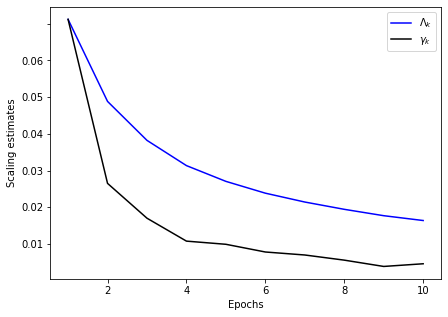

<Figure size 432x288 with 0 Axes>

In [13]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()

x = []
for i in range(epochs):
    x.append(i+1)


fig = plt.figure()
param2 = []
for i in range(epochs):
    param2.append(corr[i][2])
    
ax.plot(x,param2, label = '$ \Lambda_k$', c = 'blue')


param22 = []
for i in range(epochs):
    param22.append(sc[i][2])
ax.plot(x,param22, label = '$ \gamma_k$', c ='black')
ax.set_xlabel('Epochs')
ax.set_ylabel('Scaling estimates')
ax.legend()

a = np.linspace(0,0.06,7)
ax.set_yticklabels(a)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(0, 2.0, '0.0'),
 Text(0, 4.0, '0.007'),
 Text(0, 6.0, '0.013'),
 Text(0, 8.0, '0.02'),
 Text(0, 10.0, '0.027'),
 Text(0, 12.0, '0.033'),
 Text(0, 14.0, '0.04'),
 Text(0, 16.0, '0.047'),
 Text(0, 18.0, '0.053'),
 Text(0, 20.0, '0.06'),
 Text(0, 22.0, '')]

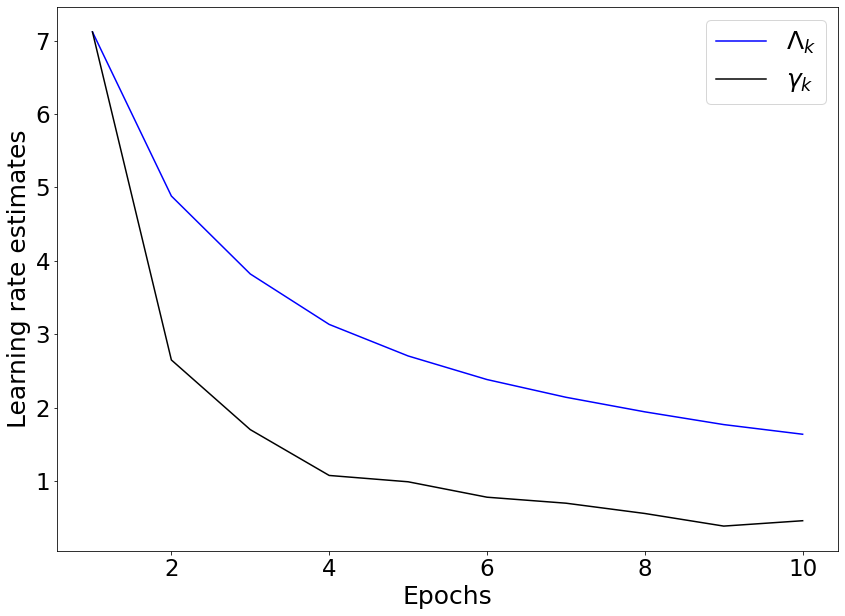

<Figure size 432x288 with 0 Axes>

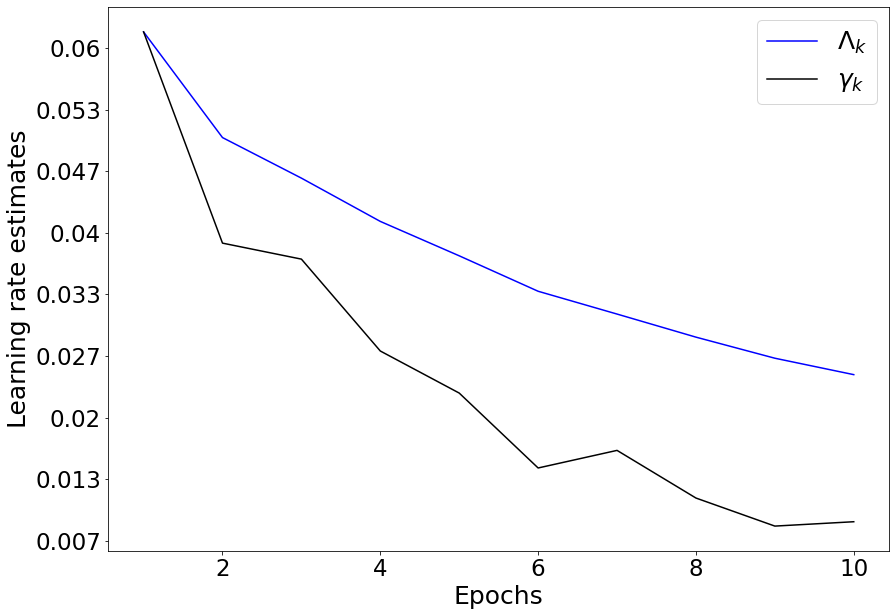

In [14]:
#print(diff,corr,sc)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot()

x = []
for i in range(epochs):
    x.append(i+1)


fig = plt.figure()
param2 = []
for i in range(epochs):
    param2.append(corr[i][2])
    
ax.plot(x,param2, label = '$ \Lambda_k$', c = 'blue')


param22 = []
for i in range(epochs):
    param22.append(sc[i][2])
ax.plot(x,param22, label = '$ \gamma_k$', c ='black')
ax.set_xlabel('Epochs',fontsize = 25)
ax.set_ylabel('Learning rate estimates',fontsize = 25)
ax.legend(fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=23)
ax.tick_params(axis='both', which='minor', labelsize=23)




fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot()

param6 = []
for i in range(epochs):
    param6.append(corr[i][6])
    
ax.plot(x,param6, label = '$ \Lambda_k$', c = 'blue')


param66 = []
for i in range(epochs):
    param66.append(sc[i][6])
ax.plot(x,param66, label = '$ \gamma_k$', c ='black')
ax.set_xlabel('Epochs',fontsize = 25)
ax.set_ylabel('Learning rate estimates',fontsize = 25)

ax.tick_params(axis='both', which='major', labelsize=23)
ax.tick_params(axis='both', which='minor', labelsize=23)
ax.legend(fontsize = 25)

a = np.linspace(0,0.06,10)
ax.set_yticklabels(np.round(a,3))

ADAM